In [1]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from transformers import DetrForObjectDetection, DetrImageProcessor
import albumentations as A
from sklearn.model_selection import train_test_split
from peft import LoraConfig, get_peft_model
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from torch.optim.lr_scheduler import StepLR

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# Paths
original_annotations_file = '_annotations.coco.json'  # Original COCO annotations file
original_images_dir = 'data'  # Directory containing original images
new_images_dir = 'data1'  # Directory to store selected images
output_annotations_file = '_annotations0.coco.json'  # New COCO annotations file

# Step 1: Load original annotations
with open(original_annotations_file) as f:
    coco_data = json.load(f)

# Step 2: Get list of all images and randomly select 10,000
all_images = coco_data['images']
selected_images = random.sample(all_images, 2000)

# Step 3: Create a set of selected image IDs
selected_image_ids = {img['id'] for img in selected_images}

# Step 4: Filter annotations based on selected images
selected_annotations = []
for annotation in coco_data['annotations']:
    if annotation['image_id'] in selected_image_ids:
        selected_annotations.append(annotation)

# Step 5: Create new list of selected images with updated info
new_images = []
for img in selected_images:
    img_path = os.path.join(original_images_dir, img['file_name'])
    if os.path.exists(img_path):  # Check if image exists
        new_images.append(img)

# Step 6: Create the new COCO format data
new_coco_data = {
    "images": new_images,
    "annotations": selected_annotations,
    "categories": coco_data['categories']  # Keep original categories
}

# Step 7: Save new annotations to a file
with open(output_annotations_file, 'w') as f:
    json.dump(new_coco_data, f)

# Step 8: (Optional) Copy selected images to a new directory
os.makedirs(new_images_dir, exist_ok=True)
for img in selected_images:
    img_src = os.path.join(original_images_dir, img['file_name'])
    img_dst = os.path.join(new_images_dir, img['file_name'])
    if os.path.exists(img_src):
        os.rename(img_src, img_dst)  # Move image to new directory


# Step 1: Load and prepare the data

In [3]:
class CustomCocoDataset(Dataset):
    def __init__(self, annotations_file, img_dir, processor, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.processor = processor

        with open(annotations_file) as f:
            self.coco = json.load(f)

        self.images = self.coco['images']
        self.annotations = self.coco['annotations']
        self.categories = {category['id']: category['name'] for category in self.coco['categories']}
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_id = img_info['id']
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        # Get annotations for this image
        boxes = []
        labels = []
        areas = []
        iscrowd = []
        for ann in self.annotations:
            if ann['image_id'] == img_id:
                boxes.append(ann['bbox'])
                labels.append(ann['category_id'])
                areas.append(ann['area'])
                iscrowd.append(ann['iscrowd'])

        # Convert boxes, labels, areas, and iscrowd to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)  # [N, 4]
        labels = torch.as_tensor(labels, dtype=torch.int64)   # [N]
        areas = torch.as_tensor(areas, dtype=torch.float32)   # [N]
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64) # [N]

        # Create target dictionary for model input
        target = {
            "size": torch.tensor(image.size),  # Size of the image
            "image_id": torch.tensor([img_id]),  # Image ID as a tensor
            "class_labels": labels,  # Class labels tensor
            "boxes": boxes,  # Bounding boxes tensor
            "area": areas,  # Area tensor
            "iscrowd": iscrowd,  # Crowd tensor
            "orig_size": torch.tensor(image.size)  # Original size of the image
        }

        # Apply transformations (albumentations for training)
        if self.transform:
            augmented = self.transform(image=np.array(image))  # Convert PIL image to NumPy array
            image = Image.fromarray(augmented['image'])  # Convert back to PIL image

        # Preprocess using the DETR processor without targets
        encoding = self.processor(images=image, return_tensors="pt")

        # Prepare the final output in the desired format
        output = (
            encoding['pixel_values'],  # Image tensor (with normalization)
            target  # Dictionary containing the target information
        )

        return output

In [4]:
# Load data
annotations_file = '_annotations0.coco.json'
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Load dataset
dataset = CustomCocoDataset(annotations_file, 'data1', processor)

# Get indices
indices = np.arange(len(dataset))
train_indices, val_test_indices = train_test_split(indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(val_test_indices, test_size=0.5, random_state=42)

# Create subsets and apply transformations
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

In [5]:
# Define albumentations transformations
train_transforms = A.Compose([
    A.HorizontalFlip(p=1.0),
    A.RandomBrightnessContrast(p=1.0)
])

train_dataset.dataset.transform = train_transforms

In [6]:
# Print the lengths of each dataset
print(f"Length of Training Set: {len(train_dataset)}")
print(f"Length of Validation Set: {len(val_dataset)}")
print(f"Length of Test Set: {len(test_dataset)}")

Length of Training Set: 1600
Length of Validation Set: 200
Length of Test Set: 200


In [7]:
# Load the annotations from the _annotations.coco.json file
with open('_annotations0.coco.json', 'r') as f:
    annotations = json.load(f)

# Extract unique labels from the categories in the annotations
unique_labels = [category['name'] for category in annotations['categories']]

# Print unique labels vertically
print("Unique Labels:")
for label in unique_labels:
    print(label)

# Print the total count of unique labels
print(f"\nTotal Unique Labels: {len(unique_labels)}")

Unique Labels:
obstacles
biker
car
pedestrian
trafficLight
trafficLight-Green
trafficLight-GreenLeft
trafficLight-Red
trafficLight-RedLeft
trafficLight-Yellow
trafficLight-YellowLeft
truck

Total Unique Labels: 12


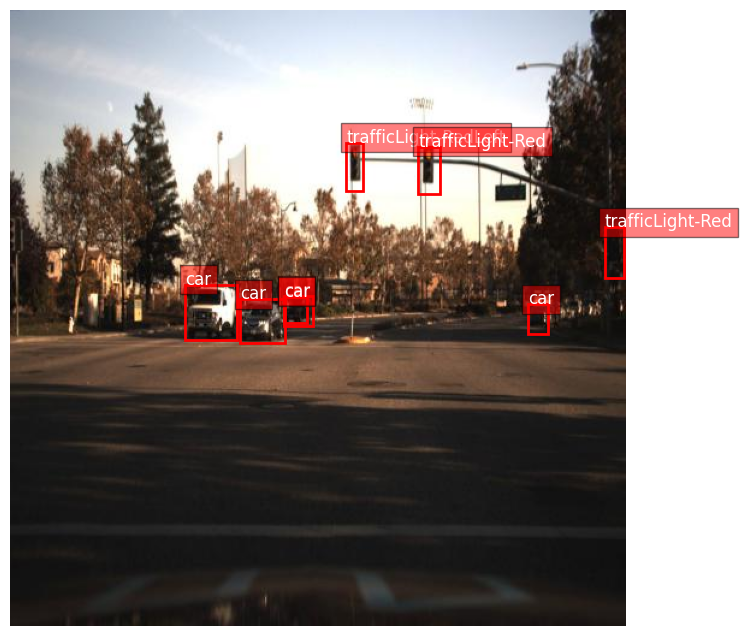

In [8]:
# Assuming `train_dataset` is a Subset of the original `CustomCocoDataset`
original_dataset = train_dataset.dataset  # Get the original dataset from the subset

# Get the data for the first image
image_tensor, target = train_dataset[0]  # Unpack to get the target

# Load the original image using the original dataset
img_info = original_dataset.images[train_dataset.indices[0]]  # Access original images via indices
img_path = os.path.join(original_dataset.img_dir, img_info['file_name'])
original_image = Image.open(img_path).convert("RGB")

# Extract bounding boxes and labels from target
boxes = target['boxes']
labels = target['class_labels']

# Convert labels to category names
categories = original_dataset.categories
label_names = [categories[label.item()] for label in labels]

# Plotting
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(original_image)

# Draw bounding boxes
for box, label in zip(boxes, label_names):
    # Create a Rectangle patch
    rect = patches.Rectangle((box[0].item(), box[1].item()), 
                             box[2].item(), box[3].item(),
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    # Add label text
    ax.text(box[0].item(), box[1].item(), label, fontsize=12, color='white',
            bbox=dict(facecolor='red', alpha=0.5))

ax.axis('off')  # Hide axes
plt.show()


# Step 2: Model initialization

In [6]:
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", num_labels=12, ignore_mismatched_sizes=True).to(device)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [58]:
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [13]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

def count_trainable_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name} | Trainable parameters: {param.numel()}")

In [78]:
print_trainable_parameters(model)

trainable params: 41282065 || all params: 41504465 || trainable%: 99.46


In [61]:
count_trainable_parameters(model)

Layer: model.backbone.conv_encoder.model.layer2.0.conv1.weight | Trainable parameters: 32768
Layer: model.backbone.conv_encoder.model.layer2.0.conv2.weight | Trainable parameters: 147456
Layer: model.backbone.conv_encoder.model.layer2.0.conv3.weight | Trainable parameters: 65536
Layer: model.backbone.conv_encoder.model.layer2.0.downsample.0.weight | Trainable parameters: 131072
Layer: model.backbone.conv_encoder.model.layer2.1.conv1.weight | Trainable parameters: 65536
Layer: model.backbone.conv_encoder.model.layer2.1.conv2.weight | Trainable parameters: 147456
Layer: model.backbone.conv_encoder.model.layer2.1.conv3.weight | Trainable parameters: 65536
Layer: model.backbone.conv_encoder.model.layer2.2.conv1.weight | Trainable parameters: 65536
Layer: model.backbone.conv_encoder.model.layer2.2.conv2.weight | Trainable parameters: 147456
Layer: model.backbone.conv_encoder.model.layer2.2.conv3.weight | Trainable parameters: 65536
Layer: model.backbone.conv_encoder.model.layer2.3.conv1.wei

In [7]:
# Freeze every layer
for param in model.parameters():
    param.requires_grad = False

In [50]:
print_trainable_parameters(model)

trainable params: 0 || all params: 41504465 || trainable%: 0.00


In [8]:
lora_config = LoraConfig(
    r=1,
    lora_alpha=16,
    lora_dropout=0.1,
    modules_to_save=["class_labels_classifier", "bbox_predictor"],
    target_modules=[
        "decoder.layers.5.encoder_attn.out_proj"
    ]
)

lora_model = get_peft_model(model, lora_config)

In [14]:
print_trainable_parameters(model)

trainable params: 136465 || all params: 41640930 || trainable%: 0.33


# Step 3: Training

In [9]:
# Hyperparameters
epochs = 10
learning_rate = 5e-5
batch_size = 8

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Define optimizer
optimizer = AdamW(lora_model.parameters(), lr=learning_rate, weight_decay=0.01)

# Define learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Adjust step_size and gamma as needed

# Function to calculate mAP
def calculate_map(predictions, annotations_file):
    coco_gt = COCO(annotations_file)
    coco_dt = coco_gt.loadRes(predictions)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats[0]

In [10]:
# Function to perform training
def train_one_epoch(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    print("Training started")
    
    for batch_idx, batch in enumerate(train_loader):
        pixel_values, targets = batch
        pixel_values = torch.stack(pixel_values).squeeze().to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=targets)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Average Training Loss: {avg_loss:.4f}")

    # Step the scheduler after each epoch
    scheduler.step()

# Function to perform validation
def validate_one_epoch(model, val_loader, annotations_file):
    model.eval()
    total_val_loss = 0
    current_epoch_predictions = []
    
    with torch.no_grad():
        for batch in val_loader:
            pixel_values, targets = batch
            pixel_values = torch.stack(pixel_values).squeeze().to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            outputs = model(pixel_values=pixel_values, labels=targets)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

            # Store predictions for mAP calculation
            boxes = outputs.pred_boxes.detach().cpu().numpy()  # Access pred_boxes directly from outputs
            logits = outputs.logits.detach().cpu()  # Access logits directly from outputs
            scores = logits.softmax(dim=-1).max(dim=-1).values  # Calculate scores

            for i, target in enumerate(targets):
                image_id = int(target['image_id'].cpu().numpy()[0])  # Convert to Python int

                for box, label, score in zip(boxes[i], logits[i].argmax(dim=-1).cpu().numpy(), scores[i]):
                    current_epoch_predictions.append({
                        "image_id": image_id,  
                        "category_id": int(label),  
                        "bbox": box.tolist(),  
                        "score": float(score)  
                    })

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Average Validation Loss: {avg_val_loss:.4f}")

    # Save predictions in COCO format for mAP calculation
    predictions_file = 'predictions.json'
    with open(predictions_file, 'w') as f:
        json.dump(current_epoch_predictions, f)

    # Calculate and print mAP for this epoch
    mAP = calculate_map(predictions_file, annotations_file)
    print(f"Mean Average Precision (mAP): {mAP:.4f}")


In [11]:
# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_one_epoch(lora_model, train_loader, optimizer, scheduler, device)
    validate_one_epoch(lora_model, val_loader, annotations_file)

# Save the trained model
lora_model.save_pretrained("lora_detr_model")

Epoch 1/10
Training started
Batch 0, Loss: 2558.0769
Batch 10, Loss: 2540.7168
Batch 20, Loss: 2755.6707
Batch 30, Loss: 2678.3862
Batch 40, Loss: 2745.2334
Batch 50, Loss: 2685.3669
Batch 60, Loss: 2479.6804
Batch 70, Loss: 2711.1089
Batch 80, Loss: 2594.2803
Batch 90, Loss: 2704.6414
Batch 100, Loss: 2705.1729
Batch 110, Loss: 2662.1602
Batch 120, Loss: 2903.0703
Batch 130, Loss: 2634.2771
Batch 140, Loss: 2422.4685
Batch 150, Loss: 2820.0352
Batch 160, Loss: 2841.4648
Batch 170, Loss: 2930.0059
Batch 180, Loss: 2802.5107
Batch 190, Loss: 2652.7510
Average Training Loss: 2654.1698
Average Validation Loss: 2656.9625
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.58s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000


# Step 4: Testing

In [12]:
def infer_and_print(model, image_path, processor, threshold=0.5):
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Preprocess the image using the DETR processor
    encoding = processor(images=image, return_tensors="pt").to(device)

    # Run inference
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values=encoding['pixel_values'])

    # Get predictions
    boxes = outputs.pred_boxes.detach().cpu().numpy()  # Get bounding boxes
    logits = outputs.logits.detach().cpu()  # Get logits

    # Apply softmax to logits and extract scores
    scores = torch.softmax(logits, dim=-1).max(dim=-1).values.detach().cpu().numpy()

    # Filter predictions by score threshold
    keep = scores >= threshold
    boxes = boxes[keep]
    scores = scores[keep]
    labels = logits.argmax(dim=-1).detach().cpu().numpy()[keep]

    # Print the results
    print("Predictions:")
    for box, score, label in zip(boxes, scores, labels):
        x_min, y_min, x_max, y_max = box
        print(f"Label: {label}, Score: {score:.2f}, Box: [{x_min:.1f}, {y_min:.1f}, {x_max:.1f}, {y_max:.1f}]")

# Example usage
image_path = 'data/1478020449702746087_jpg.rf.fUo9XyS8dXliNFV1EU9a.jpg'  # Change this to your image path
infer_and_print(lora_model, image_path, processor)

Predictions:
Label: 12, Score: 0.68, Box: [0.0, 1.0, 1.0, 1.0]
Label: 12, Score: 0.93, Box: [0.9, 0.9, 0.8, 0.9]
Label: 12, Score: 0.83, Box: [0.7, 1.0, 1.0, 1.0]
Label: 12, Score: 0.82, Box: [0.9, 0.8, 0.9, 0.9]
Label: 12, Score: 0.78, Box: [0.7, 0.4, 0.2, 0.4]
Label: 12, Score: 0.94, Box: [0.7, 0.8, 0.3, 0.4]
Label: 12, Score: 0.95, Box: [0.7, 0.9, 0.4, 0.6]
Label: 12, Score: 0.95, Box: [0.7, 0.9, 0.5, 0.9]
Label: 12, Score: 0.89, Box: [0.6, 0.9, 0.6, 1.0]
Label: 12, Score: 0.91, Box: [1.0, 1.0, 1.0, 1.0]
Label: 12, Score: 0.68, Box: [0.4, 1.0, 1.0, 1.0]
Label: 12, Score: 0.80, Box: [1.0, 1.0, 1.0, 1.0]
Label: 12, Score: 0.60, Box: [1.0, 1.0, 1.0, 1.0]
Label: 12, Score: 0.81, Box: [1.0, 1.0, 1.0, 1.0]
Label: 12, Score: 0.91, Box: [0.7, 1.0, 0.8, 1.0]
Label: 12, Score: 0.68, Box: [1.0, 1.0, 1.0, 1.0]
Label: 12, Score: 0.78, Box: [1.0, 1.0, 1.0, 1.0]
Label: 2, Score: 0.68, Box: [1.0, 1.0, 1.0, 1.0]
Label: 2, Score: 0.85, Box: [1.0, 1.0, 1.0, 1.0]
Label: 12, Score: 0.93, Box: [0.9, 0.9,